In [136]:
%matplotlib inline
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
from skimage import io, transform, color, morphology
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

In [2]:
use_gpu = torch.cuda.is_available()

In [3]:
with open('data/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt') as f:
    train_list = f.readlines()
    train_list = [train.strip() for train in train_list]
with open('data/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt') as f:
    val_list = f.readlines()
    val_list = [val.strip() for val in val_list]
print(len(train_list))
print(len(val_list))

1464
1449


float64
uint8


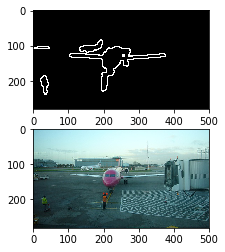

In [116]:
test = io.imread('data/VOCdevkit/VOC2012/SegmentationObject/{}.png'.format(train_list[0]))
ori_test = io.imread('data/VOCdevkit/VOC2012/JPEGImages/{}.jpg'.format(train_list[0]))
test = rgb2gray(test)
test[test > 0] = 1
test = test - morphology.erosion(test, selem=morphology.square(7))
f, axs = plt.subplots(2)
axs[0].imshow(test, cmap='gray')
axs[1].imshow(ori_test)
print(test.dtype)
print(ori_test.dtype)

In [117]:
class LegalSize(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        assert image.shape == label.shape
        h, w = image.shape[:2]
        h -= h % 16
        w -= w % 16
        img = transform.resize(image, (h, w), mode='reflect', preserve_range=True)
        lbl = transform.resize(label, (h, w), mode='reflect', preserve_range=True)
        return {'image': img, 'label': lbl}

In [118]:
class LabelEdge(object):
    def __call__(self, sample):
        _, label = sample['image'], sample['label']
        label = rgb2gray(label.astype('uint8'))
        label[label > 0] = 1
        label = label - morphology.erosion(label, selem=morphology.square(7))
        return {'image': _, 'label': label}

In [124]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1)).astype('float32') / 255
        label = label.reshape((label.shape[0], label.shape[1], 1)).transpose((2, 0, 1)).astype('float32')
        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label)}

In [125]:
class VOCDataset(Dataset):

    def __init__(self, name_list, image_dir, label_dir, transform=None):
        self.name_list = name_list
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

    def __len__(self):
        return len(self.name_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.name_list[idx] + '.jpg')
        image = io.imread(img_name)
        label_name = os.path.join(self.label_dir, self.name_list[idx] + '.png')
        label = io.imread(label_name)
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [128]:
label_dir = 'data/VOCdevkit/VOC2012/SegmentationObject/'
image_dir = 'data/VOCdevkit/VOC2012/JPEGImages/'
voc_dataset = VOCDataset(train_list, image_dir, label_dir,
                         transform=transforms.Compose([
                             LegalSize(),
                             LabelEdge(),
                             ToTensor()
                         ])
                        )
image = voc_dataset[1]['image']
label = voc_dataset[1]['label']

# f, axs = plt.subplots(2)
# axs[0].imshow(image)
# axs[1].imshow(label)
print(image[0])
print(label[0])


 0.6432  0.6665  0.6702  ...   0.2197  0.2275  0.2315
 0.6359  0.6438  0.6595  ...   0.2352  0.2391  0.2429
 0.6551  0.6594  0.6748  ...   0.2355  0.2353  0.2351
          ...             ⋱             ...          
 0.3804  0.3803  0.3880  ...   0.2461  0.2616  0.2741
 0.3575  0.3615  0.3730  ...   0.2662  0.2628  0.2631
 0.3608  0.3647  0.3650  ...   0.2859  0.2784  0.2667
[torch.FloatTensor of size 368x496]


    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 368x496]



In [9]:
vgg16 = models.vgg16(pretrained=True)

In [10]:
list(vgg16.features.children())[:24]

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 

In [170]:
class FCN(nn.Module):
    def __init__(self, vgg):
        super(FCN, self).__init__()
        self.feature1 = nn.Sequential(*list(vgg.features.children())[:24])
        self.feature2 = nn.Sequential(*list(vgg.features.children())[:17])
        self.feature3 = nn.Sequential(*list(vgg.features.children())[:10])
        self.feature4 = nn.Sequential(*list(vgg.features.children())[:5])
        self.deconv1 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.conv = nn.Conv2d(32, 1, 3, stride=1, padding=1)
#         self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        f1 = self.feature1(x)
        f2 = self.feature2(x)
        f3 = self.feature3(x)
        f4 = self.feature4(x)
        d1 = self.deconv1(f1) + f2
        d2 = self.deconv2(d1) + f3
        d3 = self.deconv3(d2) + f4
        d4 = self.deconv4(d3)
        out = self.conv(d4)
#         out = F.relu(out)
        return out

In [171]:
def train_model(model, criterion, optimizer, num_epochs=8):
    since = time.time()

    best_model_wts = model.state_dict()
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train(True)

        running_loss = 0.0

        # Iterate over data.
        for data in voc_dataset:
            # get the inputs
            inputs, labels = data['image'], data['label']
            inputs = inputs.unsqueeze(0)
            labels = labels.unsqueeze(0)
            # wrap them in Variable
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.data[0]

        epoch_loss = running_loss / len(voc_dataset)
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = model.state_dict()
        print('{} Loss: {:.4f}'.format('train', epoch_loss))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [172]:
model = FCN(vgg16)
if use_gpu:
    model.cuda()
print(model)

FCN (
  (feature1): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [173]:
criterion = nn.MSELoss()
optimizer = optim.Adam([
    {'params': model.deconv1.parameters()},
    {'params': model.deconv2.parameters()},
    {'params': model.deconv3.parameters()},
    {'params': model.deconv4.parameters()},
    {'params': model.conv.parameters()}
#     {'params': model.sigmoid.parameters()}
])

In [174]:
model = train_model(model, criterion, optimizer)
torch.save(model, './model.pt')

Epoch 0/7
----------
train Loss: 0.0244

Epoch 1/7
----------
train Loss: 57.5804

Epoch 2/7
----------
train Loss: 0.0900

Epoch 3/7
----------
train Loss: 0.0437

Epoch 4/7
----------
train Loss: 0.0350

Epoch 5/7
----------
train Loss: 0.0451

Epoch 6/7
----------
train Loss: 0.0337

Epoch 7/7
----------
train Loss: 0.0273

Training complete in 39m 56s


/home/dennis/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type FCN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Testing Model

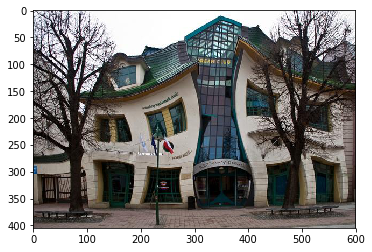

In [175]:
test_image = io.imread('data/input1.jpg')
plt.imshow(test_image)

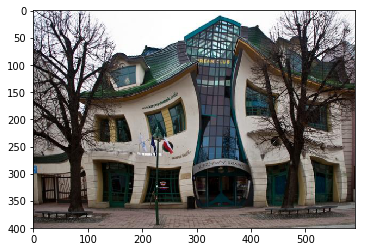

In [176]:
test_h, test_w = test_image.shape[:2]
test_h -= test_h % 16
test_w -= test_w % 16
test_image = transform.resize(test_image, (test_h, test_w), mode='reflect', preserve_range=True)
plt.imshow(test_image.astype('uint8'))

In [177]:
test_image = test_image.transpose((2, 0, 1)).astype('float32') / 255
test_image = torch.from_numpy(test_image)
test_image = test_image.unsqueeze(0)
test_image


( 0 , 0 ,.,.) = 
  0.9952  0.9342  0.7857  ...   0.9725  0.9725  0.9725
  0.9138  0.8970  0.9401  ...   0.9725  0.9725  0.9725
  0.9197  0.9904  0.9459  ...   0.9725  0.9725  0.9725
           ...             ⋱             ...          
  0.4118  0.3997  0.3965  ...   0.5608  0.5604  0.5599
  0.4463  0.4305  0.4192  ...   0.5260  0.5299  0.5338
  0.4586  0.4425  0.4152  ...   0.5061  0.5060  0.5099

( 0 , 1 ,.,.) = 
  0.9952  0.9342  0.7857  ...   0.9725  0.9725  0.9725
  0.9138  0.8970  0.9401  ...   0.9725  0.9725  0.9725
  0.9197  0.9904  0.9459  ...   0.9725  0.9725  0.9725
           ...             ⋱             ...          
  0.3569  0.3448  0.3416  ...   0.5647  0.5644  0.5639
  0.3914  0.3756  0.3643  ...   0.5299  0.5338  0.5377
  0.4037  0.3876  0.3603  ...   0.5101  0.5100  0.5138

( 0 , 2 ,.,.) = 
  0.9994  0.9656  0.8171  ...   0.9725  0.9725  0.9725
  0.9451  0.9279  0.9714  ...   0.9725  0.9725  0.9725
  0.9509  0.9957  0.9773  ...   0.9725  0.9725  0.9725
           

In [178]:
model.train(False)
# model.cpu()
out_image = model(Variable(test_image).cuda())
out_image.size()

torch.Size([1, 1, 400, 592])

In [179]:
out_image = out_image.cpu()
out_image = out_image[0].data.numpy().transpose((1, 2, 0))
out_image

array([[[-0.01815941],
        [ 0.17758606],
        [-0.06414483],
        ..., 
        [ 0.10354044],
        [ 0.08491544],
        [ 0.09534768]],

       [[-0.08744062],
        [ 0.04288954],
        [-0.03031564],
        ..., 
        [-0.00539907],
        [ 0.06232926],
        [ 0.00493057]],

       [[ 0.08119971],
        [-0.03967617],
        [ 0.04900886],
        ..., 
        [ 0.06791235],
        [ 0.0906781 ],
        [ 0.02751769]],

       ..., 
       [[ 0.00792698],
        [-0.09273762],
        [ 0.02725058],
        ..., 
        [ 0.00528186],
        [ 0.01664865],
        [ 0.11975042]],

       [[ 0.09627623],
        [-0.00232991],
        [ 0.09719977],
        ..., 
        [-0.01285968],
        [-0.11587125],
        [ 0.09311569]],

       [[ 0.0108369 ],
        [-0.06012194],
        [ 0.01737793],
        ..., 
        [ 0.02354007],
        [-0.00677764],
        [ 0.17071486]]], dtype=float32)

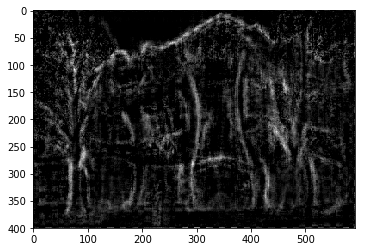

In [180]:
out_image[out_image < 0] = 0
out_image[out_image > 1] = 1
out_image *= 255
out_image = out_image.reshape((out_image.shape[0], out_image.shape[1]))
plt.imshow(out_image.astype('uint8'), cmap='gray')

In [69]:
# out_image[:, :, 0][out_image[:, :, 0] > 20] = 0
# out_image[:, :, 2][out_image[:, :, 2] > 20] = 0

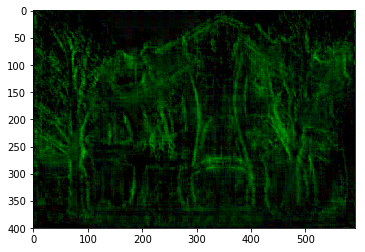

In [70]:
# plt.imshow(out_image.astype('uint8'), cmap='gray')

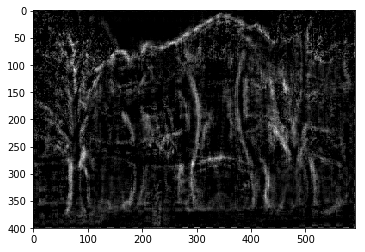

In [201]:
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.filters import threshold_otsu, threshold_local, threshold_mean
out_image_gray = rgb2gray(out_image.astype('uint8'))
plt.imshow(out_image_gray, cmap='gray')
plt.imshow(out_image, cmap='gray')

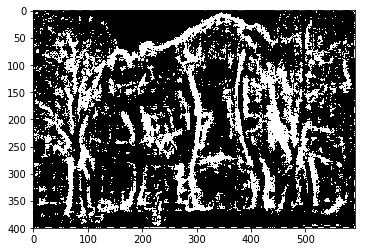

In [202]:
thresh = threshold_otsu(out_image_gray)
image_edge = out_image > thresh
plt.imshow(image_edge, cmap='gray')

# block_size = 351
# adaptive_thresh = threshold_local(out_image_gray.astype('uint8'), block_size, offset=10)
# image_edge = out_image_gray > adaptive_thresh
# plt.imshow(image_edge, cmap='gray')

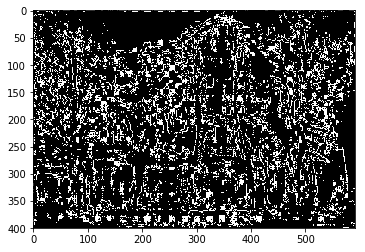

In [90]:
from skimage.morphology import erosion
image_edge_thin = np.array(image_edge == 1, dtype='uint8')
image_edge_thin = image_edge_thin - erosion(image_edge)
plt.imshow(image_edge_thin, cmap="gray")

/home/dennis/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


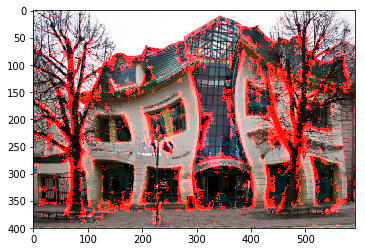

In [203]:
image = io.imread('data/input1.jpg')
h, w = image.shape[:2]
h -= h % 16
w -= w % 16
image = transform.resize(image, (h, w, 3), preserve_range=True)
image_FCN = image.copy()
red_channel = image_FCN[:, :, 0]
red_channel[image_edge == True] = 255
plt.imshow(image_FCN.astype('uint8'))

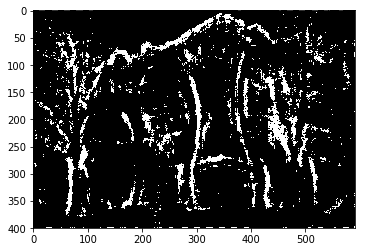

In [200]:
plt.imshow(image_edge, cmap='gray')